## This notebook is used to analyze the dataset used in the pretraining process.

### 1. An example of how to use the structure analyzer to partition a molecule into skeleton and side chains

In [1]:
# import libraries from ../pre-training/utils
import os
import sys
sys.path.append('../pre-training/utils')
from structure_analyzer import PartitionMol
from plotter import plot_mol_svg,plot_with_color

In [2]:
# import rdkit and IPython display
from rdkit import Chem
from IPython.display import HTML, SVG, display

Skeleton:


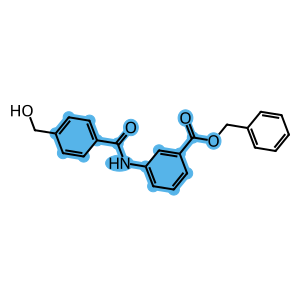

Side chains:


In [3]:
# an example of how to use the structure analyzer to partition a molecule into skeleton and side chains
smiles_example = 'O=C(Nc1cccc(C(=O)OCc2ccccc2)c1)c1ccc(CO)cc1'
mol = Chem.MolFromSmiles(smiles_example)
leaves_structure = PartitionMol(smiles_example, bone_selection="lgcs")

print("Skeleton:")  
skeleton_svg = plot_with_color(mol,leaves_structure['skeleton']['atom_idx'],
                               leaves_structure['skeleton']['bond_idx'],
                               figsize=(300,300),
                               color_id=1)
display(SVG(skeleton_svg))

print("Side chains:")
# plot the side chains in a row
html_table = '<table><tr>'


for i, side_chain in enumerate(leaves_structure['side_chains']): 
    side_chain_svg = plot_with_color(mol, 
                                   side_chain['atom_idx'],
                                   side_chain['bond_idx'],
                                   figsize=(300,300),  # Smaller size to fit in row
                                   color_id=5)
    
    # Add cell with side chain number and SVG
    html_table += f'''
        <td style="text-align: center; padding: 10px;">
            <div>Side chain #{i+1}</div>
            {side_chain_svg}
        </td>
    '''

html_table += '</tr></table>'
display(HTML(html_table))

# for i,side_chain in enumerate(leaves_structure['side_chains']): 
#     print(f"Side chain #{i+1}:")
#     side_chains_svg = plot_with_color(mol,side_chain['atom_idx'],side_chain['bond_idx'],figsize=(300,300),color_id=5)
#     display(SVG(side_chains_svg))


Skeleton:


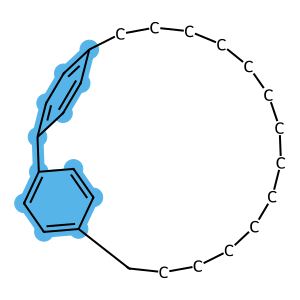

Side chains:


In [3]:
# an example of how to use the structure analyzer to partition a molecule into skeleton and side chains
smiles_example = 'C12=CC=C(CCCCCCCCCCCCCCC3=CC=C2C=C3)C=C1'
mol = Chem.MolFromSmiles(smiles_example)
leaves_structure = PartitionMol(smiles_example, bone_selection="lgcs")

print("Skeleton:")  
skeleton_svg = plot_with_color(mol,leaves_structure['skeleton']['atom_idx'],
                               leaves_structure['skeleton']['bond_idx'],
                               figsize=(300,300),
                               color_id=1)
display(SVG(skeleton_svg))

print("Side chains:")
# plot the side chains in a row
html_table = '<table><tr>'


for i, side_chain in enumerate(leaves_structure['side_chains']): 
    side_chain_svg = plot_with_color(mol, 
                                   side_chain['atom_idx'],
                                   side_chain['bond_idx'],
                                   figsize=(300,300),  # Smaller size to fit in row
                                   color_id=5)
    
    # Add cell with side chain number and SVG
    html_table += f'''
        <td style="text-align: center; padding: 10px;">
            <div>Side chain #{i+1}</div>
            {side_chain_svg}
        </td>
    '''

html_table += '</tr></table>'
display(HTML(html_table))

# for i,side_chain in enumerate(leaves_structure['side_chains']): 
#     print(f"Side chain #{i+1}:")
#     side_chains_svg = plot_with_color(mol,side_chain['atom_idx'],side_chain['bond_idx'],figsize=(300,300),color_id=5)
#     display(SVG(side_chains_svg))


In [10]:
mol = Chem.MolFromSmiles('C12=CC=C(CCCCCCCCCCCCCCC3=CC=C2C=C3)C=C1')
smiles = Chem.MolToSmiles(mol)
print(smiles)

c1cc2ccc1CCCCCCCCCCCCCCc1ccc-2cc1


In [9]:
import pandas as pd
data = pd.read_csv('/home/qianzhang/MyProject/LUMIA/explaining/lumia/prediction/attribution/hr_side_chain_cv_0_attribution_summary.csv')

data[data['smiles']=='c1ccc(-c2ccccc2)cc1']

,smiles,label,sub_name,split,sub_pred_mean,sub_pred_std,mol_pred_mean,mol_pred_std,attribution,attribution_normalized


### 2. Dataset analysis
#### 2.1. Distribution of the number of atoms of all the dataset

There are three datasets in total:
1. pre-training dataset
     - full dataset: ~1.4M molecules
     - 200k dataset: a subset of the full dataset, used for parameters tuning for pre-training
2. fine-tuning dataset
     - OCELOT dataset: organic pi-conjugated molecules, used for opto-electronic property prediction
     - QM9-sub dataset: a subset of the QM9 dataset, used for small molecule reorganization energy prediction and substructural pattern mining


In [256]:
# plot the distribution of the number of atoms of all the datasets
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline

# set the style of the plot: Arial font, 10pt, y axis using 4 ticks
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 8
plt.rcParams['axes.formatter.use_mathtext'] = True


# set the width and height of the plot in cm
def cm2inch(value):
    return value/2.54

# set the names and paths of the datasets
dataset_names = ['pre-training_full', 'pre-training_200k', 'fine-tuning_OCELOT', 'fine-tuning_QM9-sub']
dataset_paths = ['../dataset/pretrain/full_clean.csv', '../dataset/pretrain/200k.csv', '../dataset/finetune/ocelot/ocelot_clean.csv', '../dataset/finetune/qm9-sub/RE.csv']

# read the dataset
dataset_full = pd.read_csv(dataset_paths[0])
dataset_200k = pd.read_csv(dataset_paths[1])
dataset_OCELOT = pd.read_csv(dataset_paths[2])
dataset_QM9_sub = pd.read_csv(dataset_paths[3])

In [ ]:
from multiprocessing import Pool   
from functools import partial
from tqdm import tqdm
import numpy as np

# statistics of the fine-tuning_QM9-sub dataset， distribution of the number of atoms of each molecule
def get_num_atoms(smiles):
    """
    return the number of atoms of a molecule, including the number of hydrogens
    """
    mol = Chem.MolFromSmiles(smiles)
    total_atoms = Chem.AddHs(mol).GetNumAtoms()
    heavy_atoms = mol.GetNumAtoms()
    
    return total_atoms, heavy_atoms


def statistics_num_atoms(dataset, processes=32, figsize=(4,4), ylim=(0,8000),bins_total=20,bins_heavy=10,save_path=None,num_x_ticks=5):
    # parallelize the process
    with Pool(processes=processes) as pool:
        # use tqdm to show the progress of the parallelization
        results = list(tqdm(
            pool.imap(get_num_atoms, dataset['smiles']), 
            total=len(dataset)
        ))
        num_atoms, num_heavy_atoms = zip(*results)
    
    # set the width and height of the plot in cm
    width_cm = figsize[0]
    height_cm = figsize[1]
    
    plt.figure(figsize=(cm2inch(width_cm), cm2inch(height_cm)))
    # plot the distribution of the number of atoms in total and heavy atoms
    plt.hist(num_atoms, bins=bins_total, color="dodgerblue",alpha=0.3,edgecolor='none', label='Total atoms')
    plt.hist(num_atoms, bins=bins_total, histtype = "step", color="dodgerblue",linewidth=1)
    plt.hist(num_heavy_atoms, bins=bins_heavy, color="hotpink",alpha=0.3,edgecolor='none', label='Heavy atoms')
    plt.hist(num_heavy_atoms, bins=bins_heavy, histtype = "step", color="hotpink",linewidth=1)
    plt.xlabel('Number of atoms')
    plt.ylabel('Count')
    plt.legend()

    # set the y axis using scientific notation
    # plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    
    # set the y axis in log scale
    # plt.yscale('log')
    
    # set y axis limit
    if ylim is None:
        pass
    else:
        plt.ylim(ylim)
    
    # set the y axis using 4 ticks, x axis using 4 ticks
    plt.gca().yaxis.set_major_locator(MaxNLocator(4))
    plt.gca().xaxis.set_major_locator(MaxNLocator(num_x_ticks))
    
    # don't show the top and right spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    # set the y axis using scientific notation
    # plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    # plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    # set legend not shown
    plt.legend().set_visible(False)
    
    plt.tight_layout()
    
    if save_path is not None:
        plt.savefig(save_path, dpi=600,bbox_inches='tight', format='svg')
    
    plt.show()
    return num_atoms, num_heavy_atoms
    

num_atoms_OCELOT, num_heavy_atoms_OCELOT = statistics_num_atoms(dataset_OCELOT,ylim=(0,8000),bins_total=20,bins_heavy=20,save_path='./figures/num_atoms_OCELOT.svg' )
num_atoms_QM9_sub, num_heavy_atoms_QM9_sub = statistics_num_atoms(dataset_QM9_sub,bins_total=10,bins_heavy=4,ylim=None,save_path='./figures/num_atoms_QM9_sub.svg')
num_atoms_200k, num_heavy_atoms_200k = statistics_num_atoms(dataset_200k,bins_total=20,bins_heavy=10,ylim=None,save_path='./figures/num_atoms_200k.svg',num_x_ticks=4)
num_atoms_full, num_heavy_atoms_full = statistics_num_atoms(dataset_full,bins_total=30,bins_heavy=30,ylim=None,num_x_ticks=3,save_path='./figures/num_atoms_full.svg')



#### 2.2. Distribution of the number of aromatic rings of all the dataset



In [ ]:

def get_num_aromatic_rings(smiles):
    """
    Count the number of aromatic rings in a molecule given its SMILES representation.

    Args:
        smiles (str): The SMILES string of the molecule.

    Returns:
        int: Number of aromatic rings.
    """
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return "Invalid SMILES"

        # Identify ring information
        ring_info = mol.GetRingInfo()
        num_aromatic_rings = sum(1 for ring in ring_info.BondRings() if all(mol.GetBondWithIdx(b).GetIsAromatic() for b in ring))
        return num_aromatic_rings
    except Exception as e:
        return 0

def statistics_num_aromatic_rings(dataset, processes=32, figsize=(5.5,5), ylim=(0,11000),save_path=None):
    with Pool(processes=processes) as pool:
        results = list(tqdm(
            pool.imap(get_num_aromatic_rings, dataset['smiles']), 
            total=len(dataset)
        ))
        num_aromatic_rings = results
    
    # renomalize the number of aromatic rings
    # [<=2,3,4,5,6,>=7]
    # clip the number of aromatic rings to (2,7)
    num_aromatic_rings = np.clip(num_aromatic_rings, 2, 7)
    
    # set the width and height of the plot in cm
    width_cm = figsize[0]
    height_cm = figsize[1]
    
    # plot the distribution of the number of aromatic rings
    plt.figure(figsize=(cm2inch(width_cm), cm2inch(height_cm)))
    plt.bar(range(2,8), np.bincount(num_aromatic_rings, minlength=8)[2:], color="dodgerblue",alpha=0.3, label='Aromatic rings')
    plt.bar(range(2,8), np.bincount(num_aromatic_rings, minlength=8)[2:], color="none",edgecolor="dodgerblue",linewidth=1)
    
    plt.xlabel('Number of aromatic rings')
    plt.ylabel('Count')
    
    # set the y axis limit
    if ylim is None:
        pass
    else:
        plt.ylim(ylim) 
    
    
    # write the number of molecules in each bin
    for i in range(2,8):
        plt.text(i, np.bincount(num_aromatic_rings, minlength=8)[i], np.bincount(num_aromatic_rings, minlength=8)[i], ha='center', va='bottom',fontsize=6)
    
    # sey y axis in log scale
    # plt.yscale('log')
    
    # # set the right and top spines unvisible
    # plt.gca().spines['right'].set_visible(False)
    # plt.gca().spines['top'].set_visible(False)
    
    # set y axis max major locator
    plt.gca().yaxis.set_major_locator(MaxNLocator(4))
    
    # set x axis labelt
    plt.xticks(range(2,8), ['≤2', '3', '4', '5', '6', '≥7'])
    plt.tight_layout()
    
    
    if save_path is not None:
        plt.savefig(save_path, dpi=600,bbox_inches='tight', format='svg')
    
    plt.show()
    return num_aromatic_rings

# num_aromatic_rings_OCELOT = statistics_num_aromatic_rings(dataset_OCELOT,save_path='./figures/num_aromatic_rings_OCELOT.svg')
# num_aromatic_rings_200k = statistics_num_aromatic_rings(dataset_200k,save_path='./figures/num_aromatic_rings_200k.svg',ylim=(0,120000))
num_aromatic_rings_full = statistics_num_aromatic_rings(dataset_full,save_path='./figures/num_aromatic_rings_full.svg',ylim=(0,800000),figsize=(6.5,5))

#### 2.3. Distribution of the number of fused rings of all the dataset


In [ ]:

def get_num_fused_rings(smiles):
    """
    Count the number of fused aromatic rings in a molecule given its SMILES representation.

    Args:
        smiles (str): The SMILES string of the molecule.

    Returns:
        int: Number of fused aromatic rings.
    """
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return "Invalid SMILES"

        # Get ring information
        ring_info = mol.GetRingInfo()
        bond_rings = ring_info.BondRings()
        num_rings = len(bond_rings)

        # Create a set of aromatic bonds for each ring
        aromatic_bond_sets = [
            set(ring) for ring in bond_rings if all(mol.GetBondWithIdx(b).GetIsAromatic() for b in ring)
        ]

        # Count fused aromatic rings (rings sharing at least one bond)
        fused_aromatic_rings = 0
        for i in range(len(aromatic_bond_sets)):
            for j in range(i + 1, len(aromatic_bond_sets)):
                if aromatic_bond_sets[i] & aromatic_bond_sets[j]:  # Check for shared bonds
                    fused_aromatic_rings += 1
                    break

        return fused_aromatic_rings
    except Exception as e:
        return 0
    

def statistics_num_fused_rings(dataset, processes=32, figsize=(5.5,5), ylim=(0,10000),save_path=None):
    with Pool(processes=processes) as pool:
        results = list(tqdm(
            pool.imap(get_num_fused_rings, dataset['smiles']), 
            total=len(dataset)
        ))
        num_fused_rings = results
    
    # clip the number of fused rings to (0,5)
    num_fused_rings = np.clip(num_fused_rings, 0, 5)
        
    # plot the distribution of the number of fused rings
    width_cm = figsize[0]
    height_cm = figsize[1]  
    
    plt.figure(figsize=(cm2inch(width_cm), cm2inch(height_cm)))
    plt.bar(range(0,6), np.bincount(num_fused_rings, minlength=6), color="hotpink",alpha=0.5, label='Fused rings')
    plt.bar(range(0,6), np.bincount(num_fused_rings, minlength=6), color="none",edgecolor="hotpink",linewidth=1)

    plt.xlabel('Number of fused aromatic rings')
    plt.ylabel('Count')
    
    plt.xticks(range(0,6), ['0', '1', '2', '3', '4', '≥5'])
    
    # set the y axis limit
    if ylim is None:
        pass
    else:
        plt.ylim(ylim)
    
    # max y locator
    plt.gca().yaxis.set_major_locator(MaxNLocator(4))
    
    plt.tight_layout()
    
    # write the number of molecules in each bin
    for i in range(0,6):
        plt.text(i, np.bincount(num_fused_rings, minlength=6)[i], np.bincount(num_fused_rings, minlength=6)[i], ha='center', va='bottom',fontsize=6)
    
    if save_path is not None:
        plt.savefig(save_path, dpi=600,bbox_inches='tight', format='svg')
    
    plt.show()
    return num_fused_rings

num_fused_rings_OCELOT = statistics_num_fused_rings(dataset_OCELOT,save_path='./figures/num_fused_rings_OCELOT.svg',ylim=(0,15000),figsize=(5.8,5))
num_fused_rings_200k = statistics_num_fused_rings(dataset_200k,save_path='./figures/num_fused_rings_200k.svg',ylim=(0,150000),figsize=(5.8,5))
num_fused_rings_full = statistics_num_fused_rings(dataset_full,save_path='./figures/num_fused_rings_full.svg',ylim=(0,1100000),figsize=(5.8,5))


#### 2.4. Distribution of the number of substituents of all the dataset


In [ ]:
# distribution of the number of substituents of each molecule
def get_num_substituents(smiles):
    """
    Count the number of substituents of a molecule given its SMILES representation.
    """
    leaves_structure = PartitionMol(smiles, bone_selection="lgcs")
    return len(leaves_structure['side_chains'])

def statistics_num_substituents(dataset, processes=32, figsize=(5.5,5), ylim=(0,10000),save_path=None):
    with Pool(processes=processes) as pool:
        results = list(tqdm(
            pool.imap(get_num_substituents, dataset['smiles']), 
            total=len(dataset)
        ))
        num_substituents = results
    
    num_substituents = np.clip(num_substituents, 0, 5)
    
    
    # plot the distribution of the number of substituents
    width_cm = figsize[0]
    height_cm = figsize[1]
    
    
    plt.figure(figsize=(cm2inch(width_cm), cm2inch(height_cm)))
    plt.bar(range(0,6), np.bincount(num_substituents, minlength=6), color="gold",alpha=0.5, label='Substituents')
    plt.bar(range(0,6), np.bincount(num_substituents, minlength=6), color="none",edgecolor="gold",linewidth=1)

    plt.xlabel('Number of substituents')
    plt.ylabel('Count')
    
    plt.xticks(range(0,6), ['0', '1', '2', '3', '4', '≥5'])
    
    # set the y axis limit
    if ylim is None:
        pass
    else:
        plt.ylim(ylim)
    
    # max y locator
    plt.gca().yaxis.set_major_locator(MaxNLocator(4))
    
    plt.tight_layout()
    
    # write the number of molecules in each bin
    for i in range(0,6):
        plt.text(i, np.bincount(num_substituents, minlength=6)[i], np.bincount(num_substituents, minlength=6)[i], ha='center', va='bottom',fontsize=6)
    
    if save_path is not None:
        plt.savefig(save_path, dpi=600,bbox_inches='tight', format='svg')
    
    plt.show()
    return num_substituents

num_substituents_OCELOT = statistics_num_substituents(dataset_OCELOT,save_path='./figures/num_substituents_OCELOT.svg',ylim=(0,15000),figsize=(5.8,5))
num_substituents_200k = statistics_num_substituents(dataset_200k,save_path='./figures/num_substituents_200k.svg',ylim=(0,100000),figsize=(5.8,5))
num_substituents_full = statistics_num_substituents(dataset_full,save_path='./figures/num_substituents_full.svg',ylim=(0,700000),figsize=(6.5,5))

#### 2.5. Distribution of the number of different rings systems and elements of the QM9-sub dataset



In [ ]:
def get_num_different_rings(smiles):
    """
    Count the number of different rings in a molecule given its SMILES representation.
    
    return the number of three-ring system, four-ring system, five-ring system, etc.
    
    """
    # 将SMILES转换为RDKit分子对象
    mol = Chem.MolFromSmiles(smiles)
    
    # 获取所有环的大小
    ring_info = mol.GetRingInfo()
    ring_sizes = [len(ring) for ring in ring_info.AtomRings()]
    
    # 统计不同大小环的数量
    ring_counts = {}
    for size in ring_sizes:
        if size not in ring_counts:
            ring_counts[size] = 1
        else:
            ring_counts[size] += 1
            
    # 返回3-8元环的数量
    result = []
    for size in range(3,8):
        result.append(ring_counts.get(size, 0))
        
    return result

def statistics_num_different_rings(dataset, processes=32, figsize=(5.5,5), ylim=(0,10000),save_path=None):
    with Pool(processes=processes) as pool:
        results = list(tqdm(
            pool.imap(get_num_different_rings, dataset['smiles']), 
            total=len(dataset)
        ))
        num_different_rings = results
    
    # get the number of molecules with different rings
    num_with_rings = np.sum(num_different_rings,axis=0)
    
    print(f"Number of molecules with different rings: {num_with_rings}")
    # plot the distribution of the number of different rings
    width_cm = figsize[0]
    height_cm = figsize[1]
    
    # plot the distribution of the number of different rings
    plt.figure(figsize=(cm2inch(width_cm), cm2inch(height_cm)))
    plt.bar(range(3,8), num_with_rings, color="tab:green",alpha=0.5, label='Different rings')
    plt.bar(range(3,8), num_with_rings, color="none",edgecolor="tab:green",linewidth=1)

    plt.xlabel('Number of #ring systems')
    plt.ylabel('Count')
    
    plt.xticks(range(3,8), ['3', '4', '5', '6', '7'])

    # set the y axis limit
    if ylim is None:
        pass
    else:
        plt.ylim(ylim)
    
    # max y locator
    plt.gca().yaxis.set_major_locator(MaxNLocator(4))
    
    plt.tight_layout()
    
    # write the number of molecules in each bin
    for i in range(3,8):
        plt.text(i, num_with_rings[i-3], num_with_rings[i-3], ha='center', va='bottom',fontsize=6)
    
    if save_path is not None:
        plt.savefig(save_path, dpi=600,bbox_inches='tight', format='svg')
    
    plt.show()
    return num_different_rings

num_different_rings_QM9_sub = statistics_num_different_rings(dataset_QM9_sub,save_path='./figures/num_different_rings_QM9_sub.svg',ylim=(0,9000),figsize=(5.8,5))

In [ ]:
# number of molecules with different number of elements,including N,O,F,Cl,Br,I,etc.
def count_elements(smiles):
    mol = Chem.MolFromSmiles(smiles)
    elements = {'N':0, 'O':0,  'F':0}
    for atom in mol.GetAtoms():
        symbol = atom.GetSymbol()
        if symbol in elements:
            elements[symbol] = 1
    return list(elements.values())

def statistics_elements(dataset, save_path=None, ylim=None, figsize=(8,5)):
    with Pool() as pool:
        results = np.array(list(tqdm(
            pool.imap(count_elements, dataset['smiles']),
            total=len(dataset)
        )))
    
    # 统计包含各元素的分子数
    num_with_elements = np.sum(results, axis=0)
    
    print(f"Number of molecules with elements: {num_with_elements}")
    
    # 绘制柱状图
    width_cm = figsize[0]
    height_cm = figsize[1]
    
    plt.figure(figsize=(cm2inch(width_cm), cm2inch(height_cm)))
    elements = ['N', 'O',  'F']
    plt.bar(range(len(elements)), num_with_elements, color="dodgerblue", alpha=0.5)
    plt.bar(range(len(elements)), num_with_elements, color="none", edgecolor="dodgerblue", linewidth=1)
    
    plt.xlabel('Elements')
    plt.ylabel('Count')
    
    plt.xticks(range(len(elements)), elements)
    
    if ylim is not None:
        plt.ylim(ylim)
    
    plt.gca().yaxis.set_major_locator(MaxNLocator(4))
    plt.tight_layout()
    
    # 在柱子上标注具体数值
    for i, count in enumerate(num_with_elements):
        plt.text(i, count, str(count), ha='center', va='bottom', fontsize=6)
    
    if save_path is not None:
        plt.savefig(save_path, dpi=600, bbox_inches='tight', format='svg')
    
    plt.show()
    return results

elements_QM9_sub = statistics_elements(dataset_QM9_sub, save_path='./figures/elements_QM9_sub.svg', ylim=(0,14000), figsize=(5.8,5))

    
    


